FCN variational AE, from Hunter. added dataset from image directory

In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2
import numpy as np
import copy
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
batch_size = 1
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 500 # was 50
latent_dim = 2
hidden_dim = 512

Using device: cuda


In [3]:
# Define the transformation
pix_per_side = 64  # image size

# Define the transformation
transform = transforms.Compose([
  transforms.Resize((pix_per_side, pix_per_side)),  # Resize the image
  transforms.Grayscale(),                           # Convert to grayscale
  v2.ToImage(),                                     # Convert to image
  v2.ToDtype(torch.float32, scale=True),            # Convert to float32
  transforms.Lambda(lambda x: x.view(-1) - 0.5),    # Flatten the image
  #transforms.Normalize(mean=[0.5], std=[0.5])       # Normalize grayscale image
])

# Load the images from a directory
dataset = ImageFolder('C:/MyPythonCoding/MyDeepLearningCoding/images_512x512', transform=transform)

# Create a DataLoader
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False)

# Sort the classes
sorted_classes = sorted(train_loader.dataset.classes, key=lambda x: int(x.split('_')[1]))
print('dataloader labels: ', sorted_classes)
train_loader.dataset.classes = sorted_classes

print('\nDataloader Details:...\n')
print('Number of samples: ', len(train_loader.dataset))
print('Batch size: ', batch_size)
print('Number of batches: ', len(train_loader))
print('dataloader labels: ', train_loader.dataset.classes)

print('dataloader created')

dataloader labels:  ['class_0']

Dataloader Details:...

Number of samples:  16
Batch size:  1
Number of batches:  16
dataloader labels:  ['class_0']
dataloader created


In [4]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [5]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus() # scale the variance

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        ) 

    def encode(self, x, eps: float = 1e-8): #Encodes input into latent space. args: input data, eps (small float for stability). returns torch.distributions.MultivariateNormal
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist): #Reparameterizes encoded data to sample from latent space. arg: a distribution. returns torch.Tensor
        return dist.rsample()

    def decode(self, z):  #Decodes from latent space to input space. takes z (torch.Tensor). returns torch.Tensor
        return self.decoder(z)

    def forward(self, x, compute_loss: bool = True): # returns VAEOutput dataclass
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput( z_dist=dist, z_sample=z,  x_recon=recon_x, loss=None, loss_recon=None, loss_kl=None, )

        # compute loss terms
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean() # KL divergence

        loss = loss_recon + 10*loss_kl # total loss

        return VAEOutput( z_dist=dist, z_sample=z, x_recon=recon_x, loss=loss, loss_recon=loss_recon, loss_kl=loss_kl,)

In [6]:
model = VAE(input_dim=pix_per_side*pix_per_side, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 4,544,772


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=4096, bias=True)
    (9): Sigmoid()
  )
)

In [7]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [8]:
def train(model, dataloader, optimizer, prev_updates):
    model.train()  # Set the model to training mode

    for (data, target) in dataloader:
        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        #print(f'Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) ')

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

Train model...

In [9]:
prev_updates = 0
for epoch in range(num_epochs):
    if epoch%10==0: print(f'Epoch {epoch+1}/{num_epochs}...')
    prev_updates = train(model, train_loader, optimizer, prev_updates)
    

Epoch 1/500...
Epoch 11/500...
Epoch 21/500...
Epoch 31/500...
Epoch 41/500...
Epoch 51/500...
Epoch 61/500...
Epoch 71/500...
Epoch 81/500...
Epoch 91/500...
Epoch 101/500...
Epoch 111/500...
Epoch 121/500...
Epoch 131/500...
Epoch 141/500...
Epoch 151/500...
Epoch 161/500...
Epoch 171/500...
Epoch 181/500...
Epoch 191/500...
Epoch 201/500...
Epoch 211/500...
Epoch 221/500...
Epoch 231/500...
Epoch 241/500...
Epoch 251/500...
Epoch 261/500...
Epoch 271/500...
Epoch 281/500...
Epoch 291/500...
Epoch 301/500...
Epoch 311/500...
Epoch 321/500...
Epoch 331/500...
Epoch 341/500...
Epoch 351/500...
Epoch 361/500...
Epoch 371/500...
Epoch 381/500...
Epoch 391/500...
Epoch 401/500...
Epoch 411/500...
Epoch 421/500...
Epoch 431/500...
Epoch 441/500...
Epoch 451/500...
Epoch 461/500...
Epoch 471/500...
Epoch 481/500...
Epoch 491/500...


In [10]:
# encode and plot the z values for the train set
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in train_loader:
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())

In [11]:
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

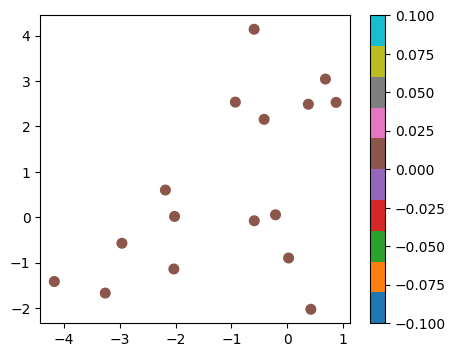

In [12]:
plt.figure(figsize=(5, 4))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=48, alpha=1)  # s=dot size, use 'c=y_all==7' etc to see individual numbers
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')


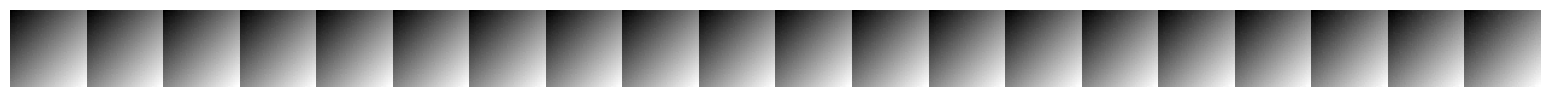

In [13]:
# interpolate between two points in the latent space
n = 20 # number of points
z1 = torch.linspace(+0.5, +2.5, n) #create a path through the z space
z2 = torch.zeros_like(z1) + 1

z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(pix_per_side, pix_per_side).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
plt.subplots_adjust(wspace=-0.2, hspace=-0.2)
plt.savefig('vae_mnist_interp.webp')

c:\MyPythonCoding\MyDeepLearningCoding\myDLvenv1\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


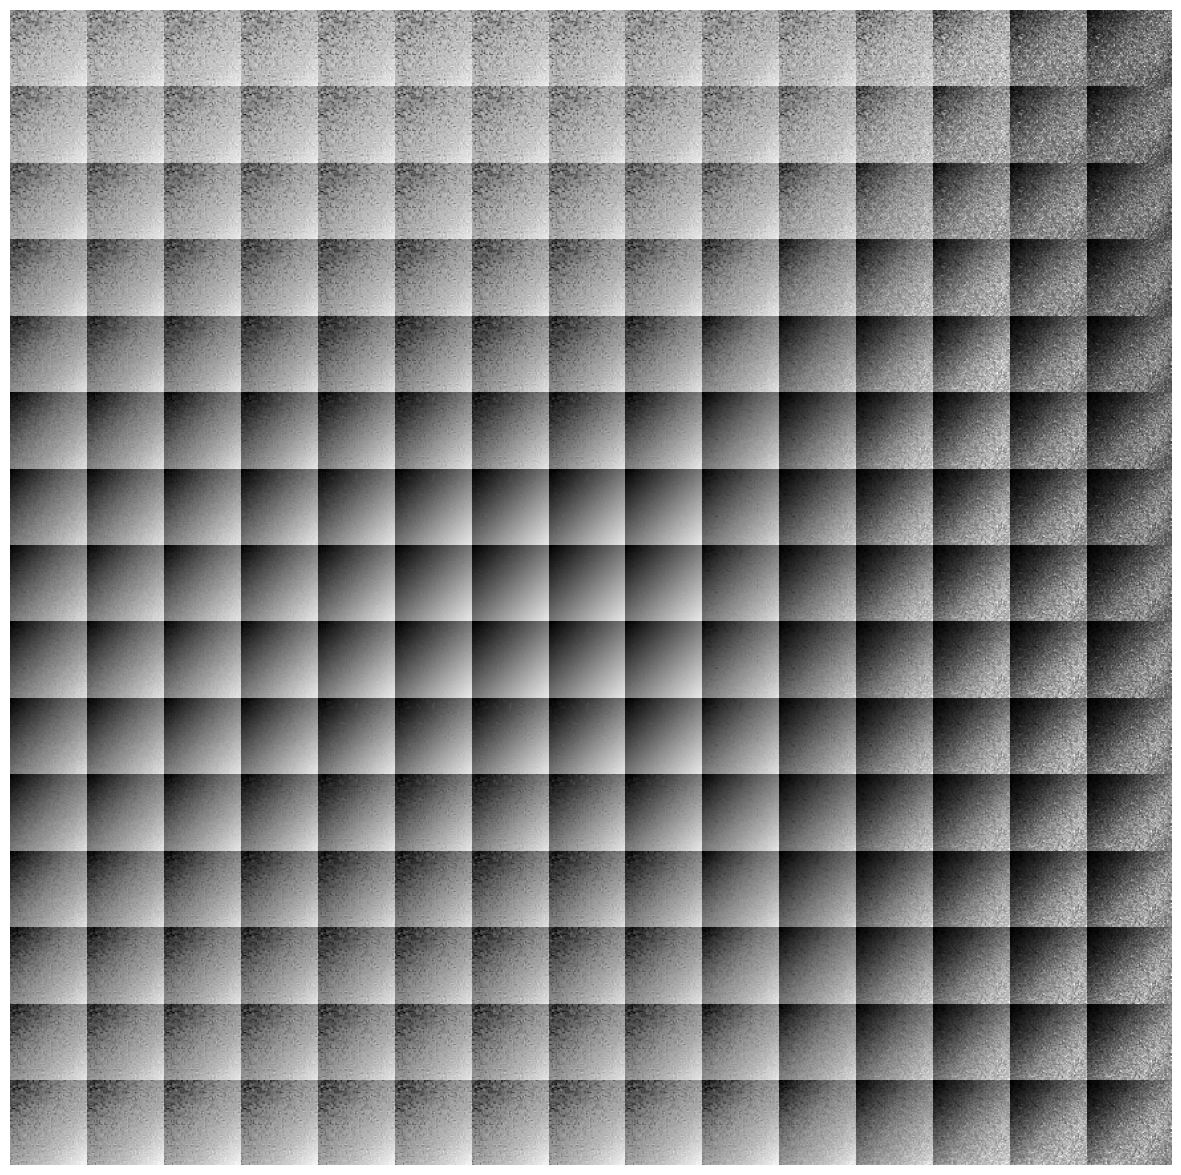

In [14]:
# use torch.meshgrid to create a grid of points in 2D z-space.
# The flatten function is used to reshape the 2D grid into a 1D array,
# which can be passed to the model.decode function.
# images are then plotted in a grid using plt.subplots.
# size of grid is determined by n x n

n = 15
z1 = torch.linspace(-10, +10, n)  # create a path through the z space
z2 = torch.linspace(-10, +10, n)  # create another path through the z space

# Create a grid of points in 2D z-space
z1, z2 = torch.meshgrid(z1, z2)
z_grid = torch.stack([z1.flatten(), z2.flatten()], dim=-1).to(device)

samples = model.decode(z_grid)
samples = torch.sigmoid(samples)

# Plot grid...
fig, ax = plt.subplots(n, n, figsize=(n, n))
for i in range(n):
    for j in range(n):
        ax[i, j].imshow(samples[i*n+j].view(pix_per_side, pix_per_side).cpu().detach().numpy(), cmap='gray') #'gray'
        ax[i, j].axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.savefig('vae_mnist_interp.webp')
